##Required Libraries

In [ ]:
# Requirements #
# !pip install -r requirements.txt
# or
!pip install numpy pandas matplotlib scikit-learn joblib feature_engine colorama


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_scorex
from sklearn.model_selection import cross_validate, StratifiedKFold

from feature_engine.encoding import WoEEncoder

from colorama import Fore, Back, Style

from joblib import dump
from joblib import load

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Dataset Overview

In [5]:
# Initialize the Train Path #
# myPATH = "tabular-playground-series-aug-2022"
myPATH = '/content/drive/MyDrive/ML-Final-Project/tabular-playground-series-aug-2022'
train = pd.read_csv(f'{myPATH}/train.csv')

# For Feature Selection #
train2 = pd.DataFrame.copy(train)
if 'failure' in train2:
    target = train2.pop('failure')

print(f'train {train.shape}')
train.head()

train (26570, 26)


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [8]:
features = []
for column in train.columns:
    if column == "loading" or column.startswith("measurement"):
        features.append(column)
print(features)


['loading', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


There are null values present in both the training and test datasets, so we need to perform imputation (replacing null values) on the data. One method is to use `KNNImputer` from `sklearn.impute` module. For now, combine the train dataset and test dataset into one whole dataset, and list all the features.

In [9]:
def impute_null_values(df, features, pcodes):

    # Impute null values in a dataframe using a KNNImputer model #

    # Create KNNImputer model with 15 neighbors
    model = KNNImputer(n_neighbors=15)
    # model = KNNImputer(n_neighbors=3)
    # model = KNNImputer(n_neighbors=5)
    
    for pcode in pcodes:
        # Get rows of data where product_code is equal to the current value of `pcode`
        mask = df['product_code'] == pcode
        feature_subset = df.loc[mask, features]
        
        # Calculate the number of null values in the feature subset before imputation
        null_before = feature_subset.isnull().sum().sum()
        
        # Use the KNN model to impute null values in the feature subset
        imputed = model.fit_transform(feature_subset)
        
        # Calculate the number of null values in the imputed feature subset
        null_after = pd.isnull(imputed).sum().sum()
        
        # Calculate the number of null values that were imputed
        null_imputed = null_before - null_after
        
        # Print a message indicating how many null values were imputed for the current product code
        print(f"Imputing Product Code {pcode}:.... \n -> {null_imputed} null values imputed")
        
        # Replace the feature subset in the original data with the imputed version
        df.loc[mask, features] = imputed
    
    return df

In [10]:
train = impute_null_values(train, features, train['product_code'].unique())
# train.query("m3_missing != 0 and m5_missing != 0").head()

Imputing Product Code A:.... 
 -> 3849 null values imputed
Imputing Product Code B:.... 
 -> 3975 null values imputed
Imputing Product Code C:.... 
 -> 4344 null values imputed
Imputing Product Code D:.... 
 -> 3973 null values imputed
Imputing Product Code E:.... 
 -> 4132 null values imputed


As we need to perform feature selection, scaling the data is an important preprocessing step. Scaling the data ensures that all features are on a similar scale, thus making it easier to compare the importance of different feature.


In [11]:
def scale_function(X, cols):
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    
    X_scaled = scaler.fit_transform(X[cols])
    X_scaled = pd.DataFrame(X_scaled, columns=cols, index=X.index)
    X_scaled = pd.concat([X.drop(cols, axis=1), X_scaled], axis=1)
    
    assert len(X) == len(X_scaled)
    
    return X_scaled

##2. Training the Model


In [20]:
def train_model(select_feature, X, y):
    # Initialize lists to store feature importances
    importance_list = []

    # Initialize variables to store average AUC and accuracy scores
    avg_auc = 0
    avg_acc = 0

    # Initialize variables to store OOF AUC and accuracy scores
    oof_auc = 0
    oof_acc = 0

    # Initialize empty arrays to store OOF predictions
    oof_preds_proba = np.zeros(len(X))
    oof_preds = np.zeros(len(X))

    # Define stratified k-fold cross-validation object with 5 splits
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Loop through the k-fold splits
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        # Split data into training and validation sets
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Scale data using the scale_data() function
        X_train_scaled = scale_function(X_train, select_feature)
        X_val_scaled = scale_function(X_val, select_feature)

        # Testing HyperParameters ------------------------------------------------------------------ 
        # Fit logistic regression model on training data
        # model = LogisticRegression(max_iter=1000, C=0.0001, penalty='l2', solver='newton-cg')
        # model = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg', random_state = 0)
        model = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1)
        model.fit(X_train_scaled[select_feature], y_train)

        # Make predictions on validation data
        val_preds_proba = model.predict_proba(X_val_scaled[select_feature])[:, 1]
        val_preds = model.predict(X_val_scaled[select_feature])

        # Compute and accumulate AUC and accuracy scores for validation set
        score = roc_auc_score(y_val, val_preds_proba)
        avg_auc += roc_auc_score(y_val, val_preds_proba) / 5
        avg_acc += accuracy_score(y_val, val_preds) / 5

        # Store OOF predictions
        oof_preds_proba[val_idx] = val_preds_proba
        oof_preds[val_idx] = val_preds

        # Append feature importances to lists
        importance_list.append(model.coef_.ravel())
        
        # Print current fold number
        print(f"Fold {fold_idx}: ROC-AUC = {score:.5f}")

    # Print average AUC and accuracy scores
    print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(avg_auc, 5)}")

    # Compute and print OOF AUC and accuracy scores
    oof_auc = roc_auc_score(y, oof_preds_proba)
    oof_acc = accuracy_score(y, oof_preds)
    print(f"{Fore.BLUE}{Style.BRIGHT}OOF auc = {round(oof_auc, 5)}")

    # Create dataframe of feature importances
    importance_df = pd.DataFrame(np.array(importance_list).T, index=X[select_feature].columns)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = X[select_feature].columns
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)

    # Plot top features as horizontal bar chart
    plt.figure(figsize=(14,4))
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('Logistic Regression Feature Importances with Feature Selection')
    plt.show()

    # Return model
    return model


###2.1 Training without Feature Selection

['loading', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']
Fold 0: ROC-AUC = 0.60100
Fold 1: ROC-AUC = 0.59172
Fold 2: ROC-AUC = 0.58052
Fold 3: ROC-AUC = 0.59276
Fold 4: ROC-AUC = 0.58383
Average auc = 0.58997
OOF auc = 0.58989


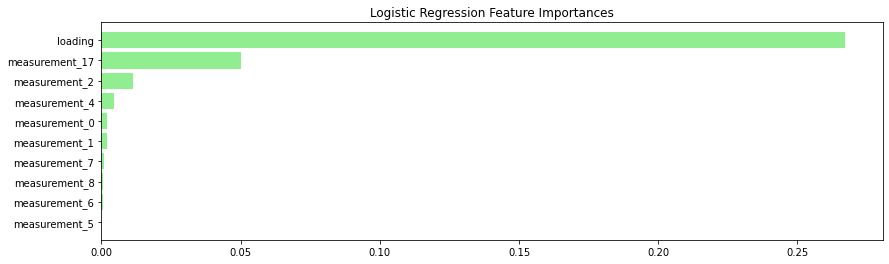

In [18]:
# Initial Training without any Feature Selection
X = train.drop(['failure'], axis=1)
y = train['failure'].astype(int)

print(features)
model1 = train_model(features, X, y)

###2.2 Training with Feature Selection

In [19]:
train2['m3_missing'] = train2['measurement_3'].isnull().astype(np.int8)
train2['m5_missing'] = train2['measurement_5'].isnull().astype(np.int8)

X_train2 = impute_null_values(train2, features, train2['product_code'].unique())

Imputing Product Code A:.... 
 -> 3849 null values imputed
Imputing Product Code B:.... 
 -> 3975 null values imputed
Imputing Product Code C:.... 
 -> 4344 null values imputed
Imputing Product Code D:.... 
 -> 3973 null values imputed
Imputing Product Code E:.... 
 -> 4132 null values imputed


In [21]:
# Encoding for attribute_0 using WoEEncoder #
woe_encoder = WoEEncoder(variables=['attribute_0'])
woe_encoder.fit(X_train2, target)

X_train2 = woe_encoder.transform(X_train2)
# X_test2 = woe_encoder.transform(X_test2)

In [ ]:
# Important Feature Engineering #
X_train2['measurement(3*5)'] = X_train2['measurement_3'] * X_train2['measurement_5']
X_train2['missing(3*5)'] = X_train2['m5_missing'] * X_train2['m3_missing']
X_train2['area'] = X_train2['attribute_2'] * X_train2['attribute_3']

X_train2[['area', 'm3_missing', 'm5_missing', 'missing(3*5)', 'measurement_3', 'measurement_5', 'measurement(3*5)']].query("m3_missing != 0 and m5_missing != 0").head()

In [23]:
optimized_features = [
    'loading',
    'attribute_0',
    'area',
    'measurement_17',
    'measurement_0',
    'measurement_1',
    'measurement_2',
    'm3_missing', 
    'm5_missing', 
    'measurement(3*5)',
    'missing(3*5)'
]

In [1]:
# print(X_train2.columns)
model2 = train_model(optimized_features, X_train2, target)

NameError: ignored

## 3. Saving the Best Model

In [ ]:
joblib.dump(model2, "my_best_model3.joblib")

NameError: ignored